In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

os.chdir("/home/ec2-user/Contacts-sensitive/graph_analysis")
import data_loading
from data_loading import state_dict
import timestep_analysis

import warnings
import scipy.optimize
warnings.filterwarnings("ignore", category=scipy.optimize.OptimizeWarning)

# Load Eigenvalues

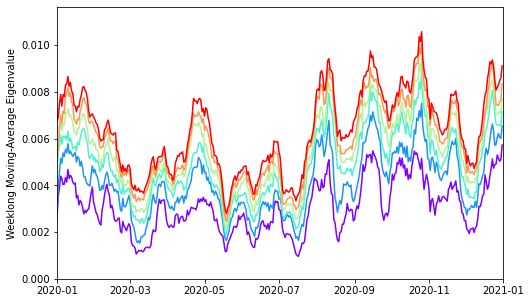

In [10]:
from matplotlib.pyplot import cm
import matplotlib.dates as mdates
import datetime
from matplotlib.dates import num2timedelta as ntd


CURRENT_STATE = 'North Carolina'
WINDOW = 7
DATE_ZERO = datetime.datetime(2020, 1, 1, 0, 0)

START_TIME = 120  # 121st day of 2020
END_TIME = 366  # First day of 2021 (not actually included)

def read_data_with_geo_averaging(state, avg_period, prefix):
    os.chdir("/home/ec2-user/Contacts-sensitive")
    eigs = timestep_analysis.read_arbitrary_output(prefix + state + '_2020-1-1_2021-1-1_1.txt')
    #eigs = timestep_analysis.read_arbitrary_output('adjacency_eigs_from_sum_contacts_by_pairs_uniform_weight__' + CURRENT_STATE + '_2020-1-1_2021-1-1_1.txt')
    for i in range(len(eigs)):
        if eigs[i] is None:
            eigs[i] = [None] * len(eigs[0])
    eigs = np.array(eigs, dtype=np.float)

    # NaN interpolation taken from https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array for ease of use
    mavg_eigs = np.zeros(eigs.shape)
    for i in range(eigs.shape[1]):
        eigs[:, i] = data_loading.geo_interp_nans(eigs[:, i])

    mavg_eigs = data_loading.left_looking_moving_average(eigs, duration=avg_period)
    return eigs, mavg_eigs

eigs, mavg_eigs = read_data_with_geo_averaging(CURRENT_STATE, WINDOW, 'eig_data/eigs_from_sum_contacts_by_pairs_laplaciansjl__')





fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_ylabel('Weeklong Moving-Average Eigenvalue')
ax.set_ylim(bottom=0, top=np.max(mavg_eigs)*1.1)
ax.set_xlim(left=DATE_ZERO, right=DATE_ZERO + ntd(mavg_eigs.shape[0]))
#ax.set_xlabel('Days since Jan 1, 2020')
cgen = iter(cm.rainbow(np.linspace(0, 1, eigs.shape[1])))
for i in range(mavg_eigs.shape[1]):
    ax.plot([DATE_ZERO + x for x in ntd(range(mavg_eigs.shape[0]))], mavg_eigs[:, i], c=next(cgen))
plt.savefig("/home/ec2-user/Plots/eigs_" + CURRENT_STATE + ".eps", dpi=400, bbox_inches='tight')
plt.show()


# plt.plot(mavg_eigs)
# plt.xticks(np.arange(0, mavg_eigs.shape[0], 30))
# plt.show()

# Load Summary Data

In [21]:
summary_data, _ = read_data_with_geo_averaging(CURRENT_STATE, WINDOW, 'summary_data/summary_data__')
num_nodes, num_edges, degree_mom_1, degree_mom_2, capped_degree_mom_1, capped_degree_mom_2 = [summary_data[:, i:i+1] for i in range(summary_data.shape[1])]

# Load Case Counts

In [22]:
# Reworking to use CDC direct data: https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36

all_state_case_data = data_loading.load_cdc_csv("~/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv")
current_state_cases = data_loading.state_case_data(all_state_case_data, CURRENT_STATE)

AVG_PERIOD = 7
current_state_average_cases = data_loading.left_looking_moving_average(current_state_cases, AVG_PERIOD)
current_state_average_cases = np.maximum(current_state_average_cases, 10)  # ===============THIS IS TO KILL DATA ANOMALIES

# plt.plot(current_state_average_cases)
# plt.show()

state_demographic_data = pd.read_csv("~/state_demographics.csv").set_index("State")  # From https://corgis-edu.github.io/corgis/ -- cite this, likely
state_demographic_data.drop("District of Columbia", inplace=True)
# print(state_demographic_data.columns)

/home/ec2-user/Contacts-sensitive/graph_analysis/data_loading.py:344: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  return raw_case_data.sort_values(by=['state','submission_date']).groupby('state')['submission_date', 'new_case']


# Generate predictors

In [23]:
import prediction_tools
data = {#'3Eigs': (eigs[:, :3], 'exponential'),
        'k=6, l=4': (data_loading.left_looking_multiaverage(eigs[:, :6], 7, 4, replacement='lin'), 'exponential'),
        #'k=6, l=4 tensorized': (data_loading.left_looking_multiaverage(eigs[:, :6], 7, 4, replacement='lin'), 'exponential-tensor:4,6'),
        'k=3, l=4': (data_loading.left_looking_multiaverage(eigs[:, :3], 7, 4, replacement='lin'), 'exponential'),
        'k=3, l=1': (data_loading.left_looking_moving_average(eigs[:, :3], 7), 'exponential'),

        'Autoregression': (np.concatenate([np.concatenate([np.zeros((n,)), current_state_average_cases[n:]/np.maximum(current_state_average_cases[:-n], 1)], axis=0)[:, np.newaxis] for n in range(1, 30)], axis=-1), 'linear'),
        '24dNoise': (np.random.normal(size=(1000, 24)), 'exponential'),
        'Null': (np.ones((1000, 1)), 'exponential'),
#         'Num nodes': (num_nodes, 'linear'),
#         'Num edges': (num_edges, 'linear'),
#         'Moment ratio': (degree_mom_2/degree_mom_1, 'linear'),
#         'Capped moment ratio': (capped_degree_mom_2/capped_degree_mom_1, 'linear'),
       }

# Summary Statistics

k=6, l=4: Optimal R^2 0.9723403402683541 achieved at offset 80
k=3, l=4: Optimal R^2 0.9373178262396046 achieved at offset 79
k=3, l=1: Optimal R^2 0.668697729895261 achieved at offset 56
Autoregression: Optimal R^2 0.421868342520499 achieved at offset 97
24dNoise: Optimal R^2 0.24142422158038124 achieved at offset 38
Null: Optimal R^2 2.220446049250313e-16 achieved at offset 79


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


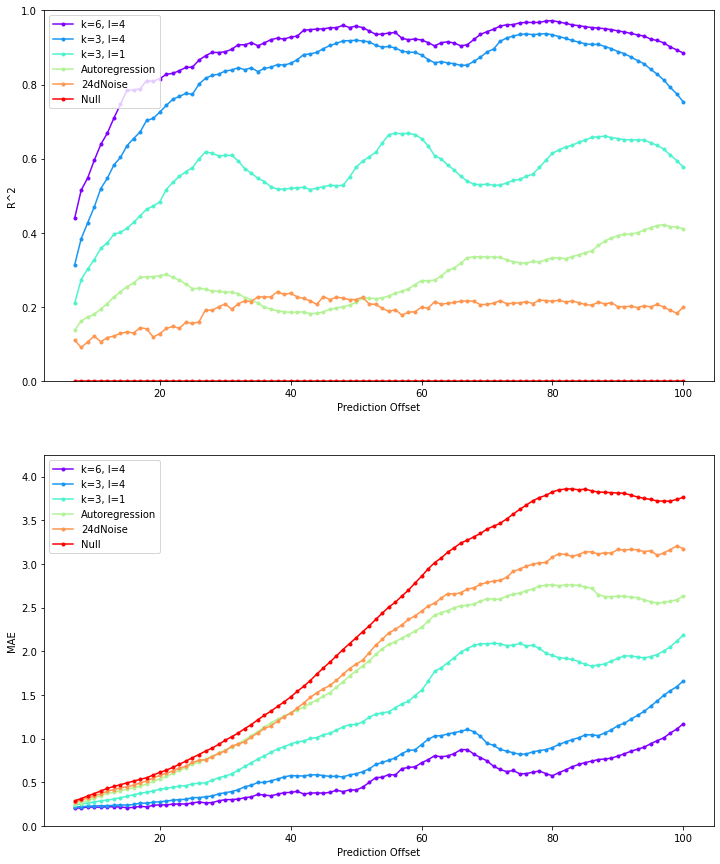

In [24]:
pred = prediction_tools.Predictor(data, current_state_average_cases, start_time=START_TIME, end_time=END_TIME, verbose=2, graph_state_name=CURRENT_STATE, offset_min=7, offset_max=100)

# Predictions when regressed on the entire dataset beforehand

k=6, l=4: Optimal R^2 0.8737807233915026 achieved at offset 28


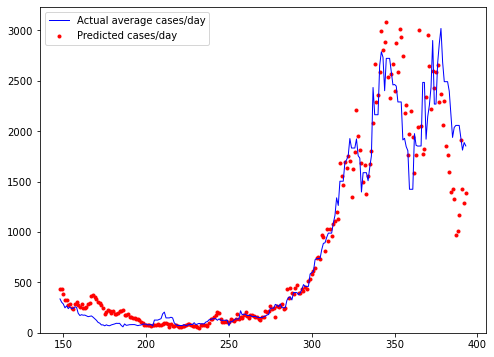

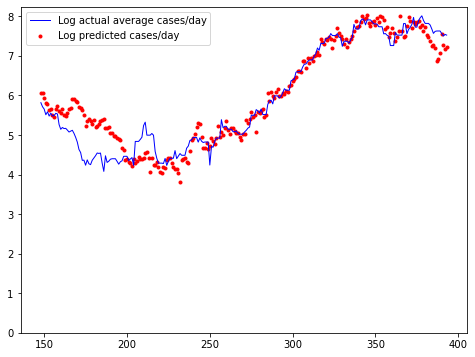

In [25]:
PRED_OFF = 28
pred_data = 'k=6, l=4'    # NOTE THAT WE ARE USING 6-EIG DATA
pred = prediction_tools.Predictor({pred_data: data[pred_data]}, current_state_average_cases, start_time=START_TIME, end_time=END_TIME+PRED_OFF, offset_min=PRED_OFF, offset_max=PRED_OFF, verbose=1)
predictions = current_state_average_cases[START_TIME:END_TIME] * pred.predict(data[pred_data][0][START_TIME:END_TIME], data_name=pred_data)

predictions = np.maximum(predictions, 1)
fix, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(range(START_TIME+PRED_OFF, END_TIME+PRED_OFF), predictions, color='red', marker='.', label='Predicted cases/day')  # Predicted case counts
ax.plot(range(START_TIME+PRED_OFF, END_TIME+PRED_OFF), current_state_average_cases[START_TIME+PRED_OFF:END_TIME+PRED_OFF], color='blue', label='Actual average cases/day', linewidth=1)  # Actual case counts
ax.legend()
ax.set_ylim(bottom=0)
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(range(START_TIME+PRED_OFF, END_TIME+PRED_OFF), np.log(predictions), color='red', marker='.', label='Log predicted cases/day')  # Predicted case counts
ax.plot(range(START_TIME+PRED_OFF, END_TIME+PRED_OFF), np.log(current_state_average_cases[START_TIME+PRED_OFF:END_TIME+PRED_OFF]), color='blue', linewidth=1, label='Log actual average cases/day')  # Actual case counts
ax.legend()
ax.set_ylim(bottom=0)
plt.show()

# Predictions using only data available on the day of prediction (PRED_OFF days before the actual day)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


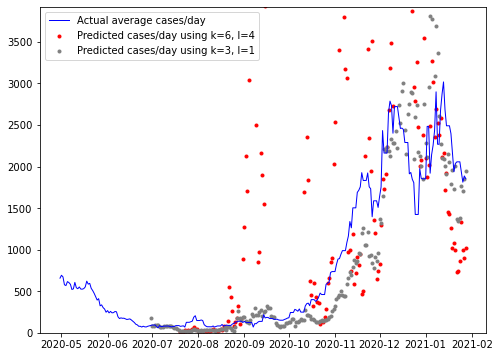

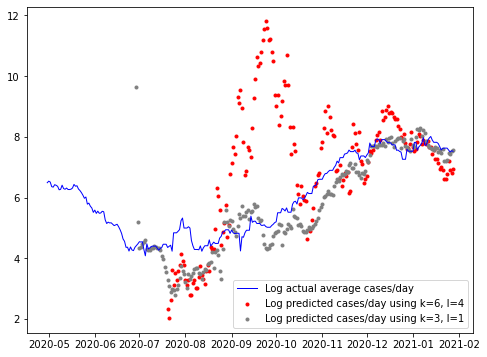

In [26]:
pred_sources = ['k=6, l=4', 'k=3, l=1'] #"k=6, l=4 tensorized"
colors = {'k=6, l=4':'red', 'k=3, l=4':'orange', 'k=3, l=1':'gray', 'k=6, l=4 tensorized':'gray'}
DIMENSION_OFFSETS = {p : (data[p][0].shape[-1]+1) for p in pred_sources}  # This exists so that we actually have enough points to do a curve fit
predictions = {p:np.zeros(current_state_average_cases[START_TIME+PRED_OFF+DIMENSION_OFFSETS[p]:END_TIME].shape) for p in pred_sources}
for p in pred_sources:
    for i in range(START_TIME+PRED_OFF+DIMENSION_OFFSETS[p], END_TIME):
        pred = prediction_tools.Predictor({pred_data: data[p]}, current_state_average_cases, start_time=START_TIME, end_time=i, offset_min=PRED_OFF, offset_max=PRED_OFF, verbose=0)
        predictions[p][i-START_TIME-PRED_OFF-DIMENSION_OFFSETS[p]] = current_state_average_cases[i] * pred.predict(data[p][0][i:i+1], pred_data)[0]
# The predictions array is offset by START_TIME+2*PRED_OFF+DIMENSION_OFFSET (in terms of the time it's predicting). This occurs because we can't actually start predicting until START_TIME+PRED_OFF+DIMENSION_OFFSET.
for p in pred_sources: 
    predictions[p] = np.maximum(predictions[p], 1)
    
    

fix, ax = plt.subplots(1, 1, figsize=(8, 6))
for p in pred_sources:
    ax.scatter([DATE_ZERO + x for x in ntd(range(START_TIME+2*PRED_OFF+DIMENSION_OFFSETS[p], END_TIME+PRED_OFF))], predictions[p], color=colors[p], marker='.', label='Predicted cases/day using '+ p)  # Predicted case counts
ax.plot([DATE_ZERO + x for x in ntd(range(START_TIME, END_TIME+PRED_OFF))], current_state_average_cases[START_TIME:END_TIME+PRED_OFF], color='blue', linewidth=1, label='Actual average cases/day')  # Actual case counts
ax.legend()
ax.set_ylim(bottom=0, top=1.3 * np.max(current_state_average_cases[START_TIME:END_TIME+PRED_OFF]))
plt.savefig("/home/ec2-user/Plots/pred_nonprescient_" + CURRENT_STATE + "_" + str(PRED_OFF) + ".eps", dpi=400, bbox_inches='tight')
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for p in pred_sources:
    ax.scatter([DATE_ZERO + x for x in ntd(range(START_TIME+2*PRED_OFF+DIMENSION_OFFSETS[p], END_TIME+PRED_OFF))], np.log(predictions[p]), color=colors[p], marker='.', label='Log predicted cases/day using '+ p)  # Predicted case counts
ax.plot([DATE_ZERO + x for x in ntd(range(START_TIME, END_TIME+PRED_OFF))], np.log(current_state_average_cases[START_TIME:END_TIME+PRED_OFF]), color='blue', linewidth=1, label='Log actual average cases/day')  # Actual case counts
ax.legend()
plt.savefig("/home/ec2-user/Plots/pred_log_nonprescient_" + CURRENT_STATE + "_" + str(PRED_OFF) + ".eps", dpi=400, bbox_inches='tight')

# All-state aggregate statistics

In [9]:
MIN_OFFSET = 28
MAX_OFFSET = 28

# Default was 7, 60


preds = {}
from data_loading import state_dict

summary_stats = {}
for state in state_dict.keys():
    print("Starting", state)
    loop_state_cases = data_loading.state_case_data(all_state_case_data, state)
    AVG_PERIOD = 7
    loop_state_average_cases = data_loading.left_looking_moving_average(loop_state_cases, AVG_PERIOD)
    loop_state_average_cases = np.maximum(loop_state_average_cases, 10)
    try:
        eigs, _ = read_data_with_geo_averaging(state, 1, 'eig_data/eigs_from_sum_contacts_by_pairs_laplaciansjl__')
        #print(eigs)
        assert np.mean(eigs) < np.max(eigs) - 1e-6  # Make sure the data is real
        assert np.mean(loop_state_average_cases) < np.max(loop_state_cases) - 1e-6
    except:
        print("Failed to load data for", state)
        continue
    
    data = {#'3Eigs': (eigs[:, :3], 'exponential'),
        'k=6, l=4': (data_loading.left_looking_multiaverage(eigs[:, :6], 7, 4, replacement='lin'), 'exponential'),
        'k=3, l=4': (data_loading.left_looking_multiaverage(eigs[:, :3], 7, 4, replacement='lin'), 'exponential'),
        'k=3, l=1': (data_loading.left_looking_moving_average(eigs[:, :3], 7), 'exponential'),
        #'4xAvgAvg6Eigs': (data_loading.left_looking_multiaverage(np.mean(eigs[:, :6], axis=1)[:, np.newaxis], 7, 4, replacement='lin'), 'exponential'),
        'Autoregression': (np.concatenate([np.concatenate([np.zeros((n,)), loop_state_average_cases[n:]/np.maximum(loop_state_average_cases[:-n], 1)], axis=0)[:, np.newaxis] for n in range(1, 30)], axis=-1), 'linear'),
        '24dNoise': (np.random.normal(size=(1000, 24)), 'exponential'),
        #'Null': (np.ones((1000, 1)), 'exponential'),
       }
    preds[state] = prediction_tools.Predictor(data, loop_state_average_cases, start_time=START_TIME, end_time=END_TIME, offset_min=MIN_OFFSET, offset_max=MAX_OFFSET, verbose=0)
    
    
    try:
        summary_data, _ = read_data_with_geo_averaging(state, WINDOW, 'summary_data/summary_data__')
        assert np.mean(summary_data) < np.max(summary_data) - 1e-6  # Make sure the data is real
    except:
        print("Failed to load summary data for", state)
        continue
    df_summary = pd.DataFrame(summary_data, columns = ["num_nodes", "num_edges", "degree_mom_1", "degree_mom_2", "capped_degree_mom_1", "capped_degree_mom_2"])
    for cname in ["num_nodes", "num_edges"]:
        df_summary[cname] = df_summary[cname].round()
    summary_stats[state] = df_summary
    
    
available_states = preds.keys()


# Note that we need the autoregression to be done with the linear model to make sense.

Starting Alabama
Starting Alaska
Starting American Samoa
Failed to load data for American Samoa
Starting Arizona
Starting Arkansas
Starting California
Starting Colorado
Starting Connecticut
Starting Delaware
Starting District of Columbia
Starting Florida
Starting Georgia
Starting Guam
Failed to load data for Guam
Starting Hawaii
Starting Idaho
Starting Illinois
Starting Indiana
Failed to load data for Indiana
Starting Iowa
Starting Kansas
Starting Kentucky
Starting Louisiana
Starting Maine
Starting Maryland
Starting Massachusetts
Starting Michigan
Starting Minnesota
Starting Mississippi
Starting Missouri
Starting Montana
Starting Nebraska
Starting Nevada
Starting New Hampshire
Starting New Jersey
Starting New Mexico
Starting New York
Starting North Carolina
Starting North Dakota
Starting Northern Mariana Islands
Failed to load data for Northern Mariana Islands
Starting Ohio
Starting Oklahoma
Starting Oregon
Starting Pennsylvania
Starting Puerto Rico
Failed to load data for Puerto Rico


In [10]:
index = state_demographic_data.index
fit_statistics = pd.DataFrame({'state':index}).set_index('state')
for predictor in preds['Connecticut'].optimal_offsets.keys():  # CT here is arbitrary -- could be any state. 
    fit_statistics[predictor + "_offset"] = pd.Series({s:preds[s].optimal_offsets[predictor] for s in available_states}).reindex(index)
    fit_statistics[predictor + '_r2'] = pd.Series({s:preds[s].r2_values[predictor][preds[s].optimal_offsets[predictor]] for s in available_states}).reindex(index)
    fit_statistics[predictor + '_mae'] = pd.Series({s:preds[s].maes[predictor][preds[s].optimal_offsets[predictor]] for s in available_states}).reindex(index)
    fit_statistics[predictor + '_mse'] = pd.Series({s:preds[s].mses[predictor][preds[s].optimal_offsets[predictor]] for s in available_states}).reindex(index)
#print(fit_statistics['4xAvg6Eigs_mae'])

In [11]:
print("Average R^2 values:")
for predictor in preds['Connecticut'].optimal_offsets.keys():
    print (predictor + ": ", round(np.nansum(fit_statistics[predictor + '_r2']) / len(fit_statistics[predictor + '_r2']), 4))

print("Average MAEs:")
for predictor in preds['Connecticut'].optimal_offsets.keys():
    print (predictor + ": ", round(np.nansum(fit_statistics[predictor + '_mae']) / len(fit_statistics[predictor + '_mae']), 4))
    
print("Average MSEs:")
for predictor in preds['Connecticut'].optimal_offsets.keys():
    print (predictor + ": ", round(np.nansum(fit_statistics[predictor + '_mse']) / len(fit_statistics[predictor + '_mse']), 4))

Average R^2 values:
k=6, l=4:  0.7522
k=3, l=4:  0.4951
k=3, l=1:  0.2016
Autoregression:  0.2025
24dNoise:  0.1186
Average MAEs:
k=6, l=4:  0.3633
k=3, l=4:  0.5455
k=3, l=1:  0.6978
Autoregression:  0.6678
24dNoise:  0.7278
Average MSEs:
k=6, l=4:  0.2453
k=3, l=4:  0.5719
k=3, l=1:  0.9691
Autoregression:  0.9489
24dNoise:  1.0292


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


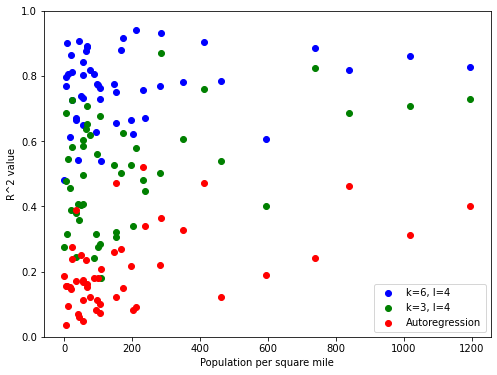

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(state_demographic_data['Population.Population per Square Mile'], fit_statistics['k=6, l=4_r2'], c='blue', label='k=6, l=4')
ax.scatter(state_demographic_data['Population.Population per Square Mile'], fit_statistics['k=3, l=4_r2'], c='green', label='k=3, l=4')
ax.scatter(state_demographic_data['Population.Population per Square Mile'], fit_statistics['Autoregression_r2'], c='red', label='Autoregression')
ax.set_xlabel("Population per square mile")
ax.set_ylabel("R^2 value")
ax.set_ylim(0, 1)
ax.legend()
#plt.show()
plt.savefig("/home/ec2-user/Plots/r2_" + str(MIN_OFFSET) + "_" + str(MAX_OFFSET) + ".eps", dpi=400, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


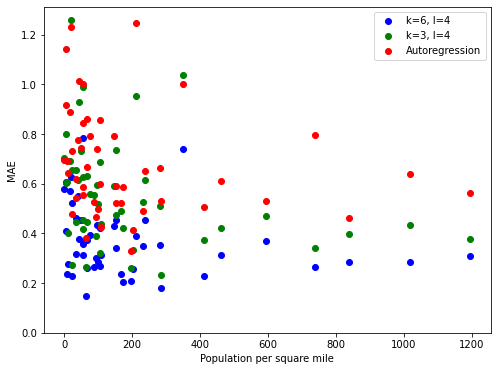

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(state_demographic_data['Population.Population per Square Mile'], fit_statistics['k=6, l=4_mae'], c='blue', label='k=6, l=4')
ax.scatter(state_demographic_data['Population.Population per Square Mile'], fit_statistics['k=3, l=4_mae'], c='green', label='k=3, l=4')
ax.scatter(state_demographic_data['Population.Population per Square Mile'], fit_statistics['Autoregression_mae'], c='red', label='Autoregression')
ax.set_xlabel("Population per square mile")
ax.set_ylabel("MAE")
ax.set_ylim(bottom=0)
ax.legend()
#plt.show()
plt.savefig("/home/ec2-user/Plots/mae_" + str(MIN_OFFSET) + "_" + str(MAX_OFFSET) + ".eps", dpi=1000, bbox_inches='tight')

# Generating Output Excel Files

In [18]:
import os

FILENAME = '/home/ec2-user/all_state_fit_statistics.xlsx'
if os.path.exists(FILENAME):
    os.remove(FILENAME)

writer = pd.ExcelWriter(FILENAME, engine='xlsxwriter')
from data_loading import state_dict
for OFFSET in (14, 28, 42, 56):
    print("Starting offset:", OFFSET)
    preds = {}
    for state in state_dict.keys():  # We reload a bunch here, but that's not horrible on performance, and it's more convenient due to the save format.
        #print("Starting", state)
        loop_state_cases = data_loading.state_case_data(all_state_case_data, state)
        AVG_PERIOD = 7
        loop_state_average_cases = data_loading.left_looking_moving_average(loop_state_cases, AVG_PERIOD)
        loop_state_average_cases = np.maximum(loop_state_average_cases, 10)
        try:
            eigs, _ = read_data_with_geo_averaging(state, 1, 'eig_data/eigs_from_sum_contacts_by_pairs_laplaciansjl__')
            assert np.mean(eigs) < np.max(eigs) - 1e-6  # Make sure the data is real
            assert np.mean(loop_state_average_cases) < np.max(loop_state_cases) - 1e-6
        except:
            print("Failed to load data for", state)
            continue
        #print(loop_state_cases, eigs)




        data = {#'3Eigs': (eigs[:, :3], 'exponential'),
            'k=6, l=4': (data_loading.left_looking_multiaverage(eigs[:, :6], 7, 4, replacement='lin'), 'exponential'),
            'k=3, l=4': (data_loading.left_looking_multiaverage(eigs[:, :3], 7, 4, replacement='lin'), 'exponential'),
            'k=3, l=1': (data_loading.left_looking_moving_average(eigs[:, :3], 7), 'exponential'),
            #'4xAvgAvg6Eigs': (data_loading.left_looking_multiaverage(np.mean(eigs[:, :6], axis=1)[:, np.newaxis], 7, 4, replacement='lin'), 'exponential'),
            'Autoregression': (np.concatenate([np.concatenate([np.zeros((n,)), loop_state_average_cases[n:]/np.maximum(loop_state_average_cases[:-n], 1)], axis=0)[:, np.newaxis] for n in range(1, 30)], axis=-1), 'linear'),
            '24dNoise': (np.random.normal(size=(1000, 24)), 'exponential'),
            #'Null': (np.ones((1000, 1)), 'exponential'),
           }
        preds[state] = prediction_tools.Predictor(data, loop_state_average_cases, start_time=START_TIME, end_time=END_TIME, offset_min=OFFSET, offset_max=OFFSET, verbose=0)
    available_states = preds.keys()
    index = state_demographic_data.index
    fit_statistics = pd.DataFrame({'state':index}).set_index('state')
    for predictor in preds['Connecticut'].optimal_offsets.keys():
        fit_statistics[predictor + "_offset"] = pd.Series({s:preds[s].optimal_offsets[predictor] for s in available_states}).reindex(index)
        fit_statistics[predictor + '_r2'] = pd.Series({s:preds[s].r2_values[predictor][preds[s].optimal_offsets[predictor]] for s in available_states}).reindex(index)
        fit_statistics[predictor + '_mae'] = pd.Series({s:preds[s].maes[predictor][preds[s].optimal_offsets[predictor]] for s in available_states}).reindex(index)
        fit_statistics[predictor + '_mse'] = pd.Series({s:preds[s].mses[predictor][preds[s].optimal_offsets[predictor]] for s in available_states}).reindex(index)
    fit_statistics.to_excel(writer, sheet_name='tau=' + str(OFFSET))
    
    fit_stats_table = fit_statistics[[d + '_' + s for d in ['k=6, l=4', 'k=3, l=1', 'Autoregression'] for s in ['r2', 'mae', 'mse']]]
    with open("/home/ec2-user/Plots/fit_stats_table_offset_" + str(OFFSET)+'.tex', 'w') as f:
        f.write(fit_stats_table.to_latex(float_format="{:0.4f}"))
writer.save()

Starting offset: 14
Failed to load data for American Samoa
Failed to load data for Guam
Failed to load data for Indiana
Failed to load data for Northern Mariana Islands
Failed to load data for Puerto Rico
Failed to load data for Virgin Islands
Starting offset: 28
Failed to load data for American Samoa
Failed to load data for Guam
Failed to load data for Indiana
Failed to load data for Northern Mariana Islands
Failed to load data for Puerto Rico
Failed to load data for Virgin Islands
Starting offset: 42
Failed to load data for American Samoa
Failed to load data for Guam
Failed to load data for Indiana
Failed to load data for Northern Mariana Islands
Failed to load data for Puerto Rico
Failed to load data for Virgin Islands
Starting offset: 56
Failed to load data for American Samoa
Failed to load data for Guam
Failed to load data for Indiana
Failed to load data for Northern Mariana Islands
Failed to load data for Puerto Rico
Failed to load data for Virgin Islands


In [19]:
import os

EIGS_FILENAME = '/home/ec2-user/all_state_eigs_2020.xlsx'
SUMMARY_FILENAME = '/home/ec2-user/all_state_summary_2020.xlsx'
if os.path.exists(EIGS_FILENAME):
    os.remove(EIGS_FILENAME)
if os.path.exists(SUMMARY_FILENAME):
    os.remove(SUMMARY_FILENAME)
eigs_writer = pd.ExcelWriter(EIGS_FILENAME, engine='xlsxwriter')
summary_writer = pd.ExcelWriter(SUMMARY_FILENAME, engine='xlsxwriter')

for state in state_dict.keys():  # We reload a bunch here, but that's not horrible on performance, and it's more convenient due to the save format.
    try:
        eigs, _ = read_data_with_geo_averaging(state, WINDOW, 'eig_data/eigs_from_sum_contacts_by_pairs_laplaciansjl__')
        assert np.mean(eigs) < np.max(eigs) - 1e-6  # Make sure the data is real
    except:
        print("Failed to load eig data for", state)
        continue
    #print(loop_state_cases, eigs)
    df_eigs = pd.DataFrame(eigs, columns = ["lambda_" + str(i) for i in range(1, eigs.shape[1]+1)])
    df_eigs.to_excel(eigs_writer, sheet_name=state)
    
    try:
        summary_data, _ = read_data_with_geo_averaging(state, WINDOW, 'summary_data/summary_data__')
        assert np.mean(summary_data) < np.max(summary_data) - 1e-6  # Make sure the data is real
    except:
        print("Failed to load summary data for", state)
        continue
    df_summary = pd.DataFrame(summary_data, columns = ["num_nodes", "num_edges", "degree_mom_1", "degree_mom_2", "capped_degree_mom_1", "capped_degree_mom_2"])
    for cname in ["num_nodes", "num_edges"]:
        df_summary[cname] = df_summary[cname].round()
    df_summary.to_excel(summary_writer, sheet_name=state)
    
eigs_writer.save()
summary_writer.save()

Failed to load eig data for American Samoa
Failed to load eig data for Guam
Failed to load eig data for Indiana
Failed to load eig data for Northern Mariana Islands
Failed to load eig data for Puerto Rico
Failed to load eig data for Virgin Islands
